# Verify `cosmopower-jax` outputs of $H(z)$ and $D_A(z)$ against `astropy` counterparts

We verify the $H(z)$ and $D_A(z)$ output by `cosmopower-jax` against the `astropy` outputs.

## Import modules

In [1]:
import os, sys

import jax
jax.config.update('jax_enable_x64', False)
import jax.numpy as jnp
from functools import partial
from jax.custom_derivatives import custom_jvp
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX

import numdifftools as nd
import numpy as np
import astropy.units as au
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "font.family": "STIXGeneral",
    "font.sans-serif": "Computer Modern",
    "font.size": 22})

## Load emulators

In [2]:
cosmology_emulator_path='/Users/nguyenmn/cosmopower-jax-for-pfs/cosmology/lcdm'

# Enable double precision
jax.config.update("jax_enable_x64", True)

# Hz_emulator, DAz_emulator objects
Hz_emulator_file='growth-and-distances/HZ_v1'
Hz_emulator_format='.npz'
Hz_emulator = CosmoPowerJAX(probe='custom_log', filepath=os.path.join(cosmology_emulator_path,Hz_emulator_file+Hz_emulator_format))
print("Emulator input parameters:",Hz_emulator.parameters)
DAz_emulator_file='growth-and-distances/DAZ_v1'
DAz_emulator_format='.npz'
DAz_emulator = CosmoPowerJAX(probe='custom', filepath=os.path.join(cosmology_emulator_path,DAz_emulator_file+DAz_emulator_format))
print("Emulator input parameters:",DAz_emulator.parameters)

#DR_emulator_file='derived-parameters/DER_v1'
#DR_emulator_format='.npz'
#DR_emulator = CosmoPowerJAX(probe='custom_log', filepath=os.path.join(cosmology_emulator_path,DR_emulator_file+DR_emulator_format))
#print("Emulator input parameters:",DR_emulator.parameters)

Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, in case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Emulator input parameters: ListWrapper(['ln10^{10}A_s', 'n_s', 'H0', 'omega_b', 'omega_cdm'])
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back

## Define cosmology

We adopt the cosmology in [Planck 2018 results. VI. Cosmological parameters](https://arxiv.org/abs/1807.06209), specifically the `TT,TE,EE+lowE+lensing+BAO` column in their Table 2.

In [3]:
# Relevant parameters for `cosmopower-jax` - LCDM
## P_lin parameters
H0 = jnp.array([67.37,])
ombh2 = 0.02233*jnp.ones_like(H0)
omch2 = 0.1198*jnp.ones_like(H0)
n_s = 0.9652*jnp.ones_like(H0)
A_s = 3.043*jnp.ones_like(H0) # ln(10^{10}A_s)

# Redshift
z = 0.0*jnp.ones_like(H0)

cosmo_dict = {'ln10^{10}A_s': A_s, 'n_s': n_s,\
                    'H0': H0,\
             'omega_b': ombh2, 'omega_cdm': omch2}

## Emulate and compare distance quantities

### $H(z)$

In [4]:
c=3E5 # speed of light in vacuum
Hz=c*Hz_emulator.predict(cosmo_dict)
zmin=0.
zmax=20.
z=np.linspace(zmin,zmax,Hz.shape[0])*cu.redshift

equivalency=cu.redshift_hubble(Planck18)
Hz_astropy=z.to(au.km / au.s / au.Mpc, equivalency)

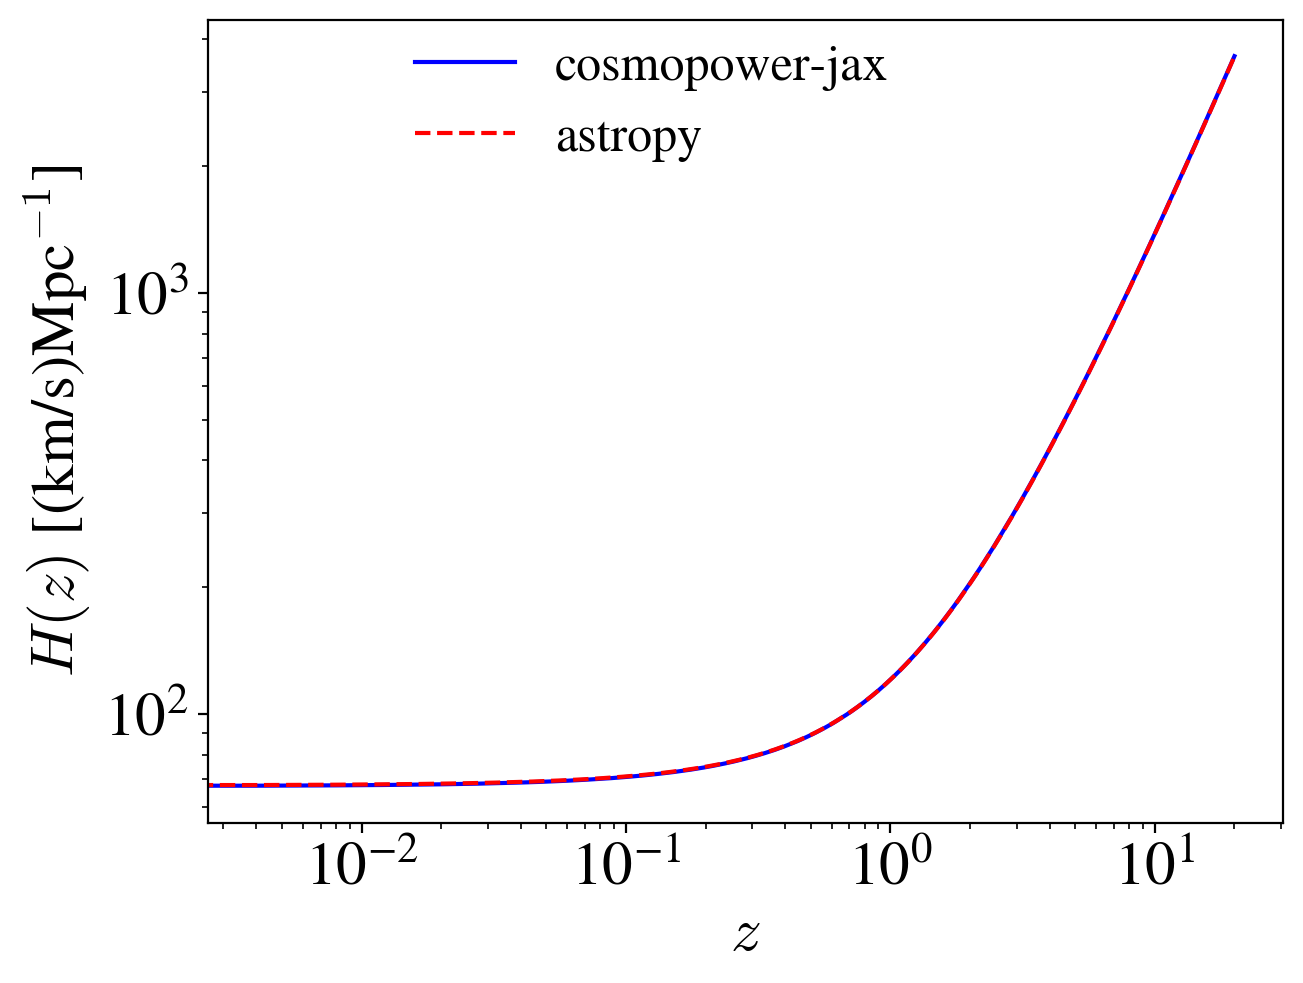

In [6]:
fig,ax=plt.subplots(constrained_layout=True)
ax.loglog(z,Hz,c='b',label='cosmopower-jax')
ax.loglog(z,Hz_astropy,ls='--',c='r',label='astropy')
ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$ [(km/s)Mpc$^{-1}$]')
fig.legend(frameon=False,loc='upper center',fontsize=18)

### $D_A(z)$

In [7]:
DAz=DAz_emulator.predict(cosmo_dict)
DAz_astropy = Planck18.angular_diameter_distance(z)

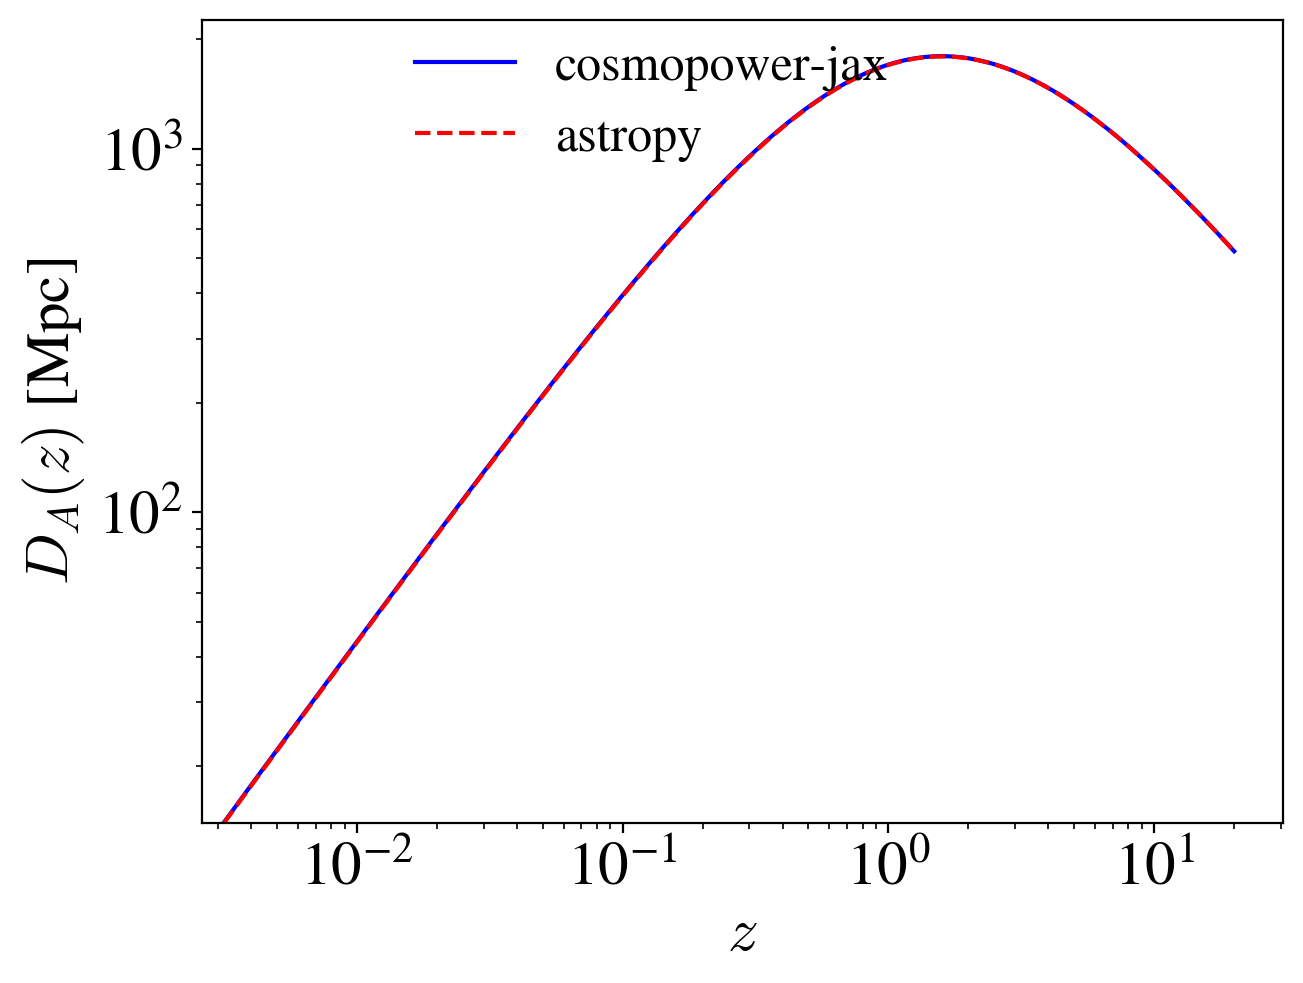

In [9]:
fig,ax=plt.subplots(constrained_layout=True)
ax.loglog(z,DAz,c='b',label='cosmopower-jax')
ax.loglog(z,DAz_astropy,ls='--',c='r',label='astropy')
ax.set_xlabel('$z$')
ax.set_ylabel('$D_A(z)$ [Mpc]')
fig.legend(frameon=False,loc='upper center',fontsize=18)